In [1]:
import os
import random
from typing import Optional
import math
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10


In [2]:
# 設定
SEED = 42
BATCH_SIZE = 128
EPOCHS = 20
LR = 3e-4
WEIGHT_DECAY = 0.05
IMAGE_SIZE = 32        # CIFAR-10は32x32
PATCH_SIZE = 4         # 4x4パッチ -> (32/4)^2 = 64 トークン
NUM_CLASSES = 10
D_MODEL = 192          # 埋め込み次元
NUM_HEADS = 3
MLP_DIM = 512
NUM_LAYERS = 6
DROPOUT = 0.1
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CHECKPOINT_DIR = "./checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

In [3]:
# 再現性のためのシード設定
def set_seed(seed=SEED):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed()

ViTは画像を直接パッチングして埋め込み表現化する。

あとは直接アテンションで解析する。

In [11]:
# パッチ化
class PatchEmbedding(nn.Module):
  def __init__(self, img_size:int, patch_size:int, in_channels:int=3, embed_dim:int=192):
    super().__init__()
    assert img_size % patch_size == 0, 'Image dimensions must be divisible by the patch size.'
    self.num_patches = (img_size // patch_size) ** 2
    # COnv2dでパッチ分割＋線形写像を行う
    self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

  def forward(self, x):
    x = self.proj(x)
    B, C, Hn, Wn = x.shape
    x = x.flatten(2).transpose(1,2)  # B, N_patches, embed_dim
    return x

# --- 確認用 ---
img = torch.randn(1, 3, 224, 224)  # 1枚の画像
patch_embed = PatchEmbedding(img_size=224, patch_size=16, embed_dim=192)
tokens = patch_embed(img)

print("返り値の形:", tokens.shape)
# 出力: torch.Size([1, 196, 192])

返り値の形: torch.Size([1, 196, 192])


In [6]:
import requests
image_url = "https://cdn.pixabay.com/photo/2020/09/16/13/04/squirrel-5576310_1280.jpg"
image_path =  "downloaded_image.jpg"
# Send a GET request to the image URL
response = requests.get(image_url)

# Check if the request was successful
if response.status_code == 200:
    # Save the image to a file
    with open(image_path, "wb") as file:
        file.write(response.content)
    print("Image downloaded successfully!")
else:
    print(f"Failed to download image. Status code: {response.status_code}")

Image downloaded successfully!


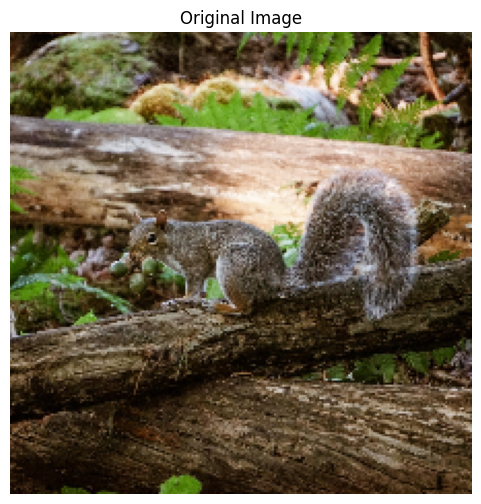

img_tensor.shape: torch.Size([224, 224, 3])


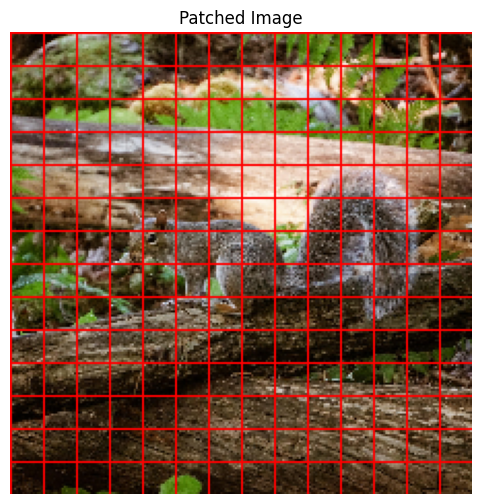

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. cv2で画像を読み込む
img = cv2.imread(image_path)  # BGR, H×W×C
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # RGBに変換
img = cv2.resize(img, (224, 224))          # サイズ調整

plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis('off')
plt.title("Original Image")
plt.show()

# 2. numpy -> torch.Tensor
img_tensor = torch.from_numpy(img).float()      # float32に変換
img_tensor = img_tensor / 255.0                # 0-1に正規化


print("img_tensor.shape:", img_tensor.shape)

# 3. バッチ次元を追加
img_tensor = img_tensor.permute(2,0,1).unsqueeze(0)  # HWC -> NCHW, バッチ次元追加

patch_embed = PatchEmbedding(img_size=224, patch_size=16, embed_dim=192)
tokens = patch_embed(img_tensor)

# 4. パッチ境界を可視化
img_patch = img.copy()
patch_size = 16
H, W, _ = img_patch.shape
for i in range(0, H, patch_size):
    cv2.line(img_patch, (0, i), (W, i), (255,0,0), 1)
for j in range(0, W, patch_size):
    cv2.line(img_patch, (j, 0), (j, H), (255,0,0), 1)

plt.figure(figsize=(6,6))
plt.imshow(img_patch)
plt.axis('off')
plt.title("Patched Image")
plt.show()